In [1]:
import  numpy as np
import  matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GroupKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
from time import time
import librosa
from scipy.spatial.distance import cosine



---
# load data

---

In [2]:
activity_codes_mapping = {'A': 'walking',
                          'D': 'sitting',
                          'E': 'standing',
                          'F': 'typing',
                          'J': 'eating',
                          'K': 'drinking',}

activity_color_map = {activity_codes_mapping['A']: 'lime',
                      activity_codes_mapping['D']: 'orange',
                      activity_codes_mapping['E']: 'yellow',
                      activity_codes_mapping['F']: 'lightgreen',
                      activity_codes_mapping['J']: 'cyan',
                      activity_codes_mapping['K']: 'purple',}

In [121]:
# watch gyro data
columns=['user','activity','time','x','y','z']
data_watch_gyro_sum = pd.DataFrame(data=None,columns=columns)
for dirname, _, filenames in os.walk('wisdm/wisdm-dataset/wisdm-dataset/wisdm-dataset/raw/watch/gyro'):
    for filename in filenames:
        df = pd.read_csv('wisdm/wisdm-dataset/wisdm-dataset/wisdm-dataset/raw/watch/gyro/'+filename , sep=",", header=None)
        temp=pd.DataFrame(data=df.values, columns=columns)
        data_watch_gyro_sum=pd.concat([data_watch_gyro_sum,temp])

print(data_watch_gyro_sum)

data_watch_gyro_sum['z'] = data_watch_gyro_sum['z'].str.replace(';','')
data_watch_gyro_sum['x']=data_watch_gyro_sum['x'].astype('float')
data_watch_gyro_sum['y']=data_watch_gyro_sum['y'].astype('float')
data_watch_gyro_sum['z']=data_watch_gyro_sum['z'].astype('float')

data_watch_gyro_sum = data_watch_gyro_sum[data_watch_gyro_sum.iloc[:, 1].isin(['A', 'D', 'E', 'F', 'J', 'K'])]
data_watch_gyro_sum.drop(['user'], axis=1, inplace=True)
print(data_watch_gyro_sum)

# watch accel data
columns=['user','activity','time','x','y','z']
data_watch_accel_sum = pd.DataFrame(data=None,columns=columns)
for dirname, _, filenames in os.walk('wisdm/wisdm-dataset/wisdm-dataset/wisdm-dataset/raw/watch/accel'):
    for filename in filenames:
        df = pd.read_csv('wisdm/wisdm-dataset/wisdm-dataset/wisdm-dataset/raw/watch/accel/'+filename , sep=",", header=None)
        temp=pd.DataFrame(data=df.values, columns=columns)
        data_watch_accel_sum=pd.concat([data_watch_accel_sum,temp])
        
print(data_watch_accel_sum)

data_watch_accel_sum['z'] = data_watch_accel_sum['z'].str.replace(';','')
data_watch_accel_sum['x']=data_watch_accel_sum['x'].astype('float')
data_watch_accel_sum['y']=data_watch_accel_sum['y'].astype('float')
data_watch_accel_sum['z']=data_watch_accel_sum['z'].astype('float')

data_watch_accel_sum = data_watch_accel_sum[data_watch_accel_sum.iloc[:, 1].isin(['A', 'D', 'E', 'F', 'J', 'K'])]
data_watch_accel_sum.drop(['user'], axis=1, inplace=True)
print(data_watch_accel_sum)

# combine watch gyro and accel data
# data_watch_sum = pd.concat([data_watch_gyro_sum, data_watch_accel_sum])
# print(data_watch_sum)

       user activity             time         x         y             z
0      1639        A  182803804703000   0.36432 -0.879908     1.212271;
1      1639        A  182803845121000 -0.797883  1.950499  -0.39414784;
2      1639        A  182803885538000  0.335558   2.55983   -1.7896442;
3      1639        A  182803925089000  1.030111 -0.428236   -1.3283848;
4      1639        A  182803965213000 -2.098571  1.634116    -1.160073;
...     ...      ...              ...       ...       ...           ...
64874  1610        S   18917068249901  -0.50843  0.602261  0.061357632;
64875  1610        S   18917118178041  0.014615  0.945276  -0.16980475;
64876  1610        S   18917168106181  3.126252  1.933841  -0.83666027;
64877  1610        S   18917218034321  3.550228  2.166069    -1.326682;
64878  1610        S   18917267962461  4.390721  2.102153   -1.6675665;

[3440342 rows x 6 columns]
      activity             time         x         y         z
0            A  182803804703000  0.364320 -0.8

---
# use local data as training data

---

In [178]:
# use local walking accel data as training data
local_watch_accel_walking = pd.read_csv('local/walking/walking/walking.csv' , sep=",", header=0, index_col=False ,names = ['time','sensor','accelx','accely','accelz','AVx','AVy','AVz','Ax','Ay','Az','temp'])

local_watch_accel_walking.drop(['sensor','AVx','AVy','AVz','Ax','Ay','Az','temp'], axis = 1, inplace = True)
local_watch_accel_walking.columns = ['time','x', 'y', 'z']
local_watch_accel_walking.insert(0, 'activity', 'A')

data_watch_accel_sum = data_watch_accel_sum[data_watch_accel_sum.iloc[:, 0].isin(['D', 'E', 'F', 'J', 'K'])]
data_accel_local_sum_0 = pd.concat([data_watch_accel_sum, local_watch_accel_walking], ignore_index=True)
print(data_accel_local_sum_0)

# use local standing accel data as training data
local_watch_accel_standing = pd.read_csv('local/standing/standing.csv' , sep=",", header=0, index_col=False ,names = ['time','sensor','accelx','accely','accelz','AVx','AVy','AVz','Ax','Ay','Az','temp'])

local_watch_accel_standing.drop(['sensor','AVx','AVy','AVz','Ax','Ay','Az','temp'], axis = 1, inplace = True)
local_watch_accel_standing.columns = ['time','x', 'y', 'z']
local_watch_accel_standing.insert(0, 'activity', 'E')

data_accel_local_sum_0 = data_accel_local_sum_0[data_accel_local_sum_0.iloc[:, 0].isin(['A', 'D', 'F', 'J', 'K'])]
data_accel_local_sum_1 = pd.concat([data_accel_local_sum_0, local_watch_accel_standing], ignore_index=True)
print(data_accel_local_sum_1)

# use local sitting accel data as training data
local_watch_accel_sitting = pd.read_csv('local/sitting/sitting.csv' , sep=",", header=0, index_col=False ,names = ['time','sensor','accelx','accely','accelz','AVx','AVy','AVz','Ax','Ay','Az','temp'])

local_watch_accel_sitting.drop(['sensor','AVx','AVy','AVz','Ax','Ay','Az','temp'], axis = 1, inplace = True)
local_watch_accel_sitting.columns = ['time','x', 'y', 'z']
local_watch_accel_sitting.insert(0, 'activity', 'D')

data_accel_local_sum_1 = data_accel_local_sum_1[data_accel_local_sum_1.iloc[:, 0].isin(['A', 'E', 'F', 'J', 'K'])]
data_accel_local_sum_2 = pd.concat([data_accel_local_sum_1, local_watch_accel_sitting], ignore_index=True)
print(data_accel_local_sum_2)

        activity             time         x         y         z
0              D  349285545742917  0.190339 -5.708974  8.047360
1              D  349285595242917  0.132878 -5.749675  7.968352
2              D  349285644742917  0.211887 -5.704186  7.819911
3              D  349285694242917  0.209493 -5.823895  8.066514
4              D  349285743742917  0.125696 -5.577293  7.927651
...          ...              ...       ...       ...       ...
1174534        A     10:00:48.873 -0.079000  0.662000 -0.080000
1174535        A     10:00:48.873 -0.079000  0.631000 -0.072000
1174536        A     10:00:48.873 -0.081000  0.631000 -0.072000
1174537        A     10:00:48.873 -0.081000  0.605000 -0.055000
1174538        A     10:00:48.873 -0.079000  0.605000 -0.055000

[1174539 rows x 5 columns]
        activity             time         x         y         z
0              D  349285545742917  0.190339 -5.708974  8.047360
1              D  349285595242917  0.132878 -5.749675  7.968352
2           

---
# compute features

---

In [179]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
import librosa

def compute_features(window):
    features = {}
    for axis in ['x', 'y', 'z']:
        # Histogram features
        hist, bin_edges = np.histogram(window[axis], bins=10, density=True)
        bin_range = np.ptp(window[axis])
        bin_width = bin_range / 10
        features.update({f'{axis}{i}': count for i, count in enumerate(hist * bin_width)})

        # Average
        features[f'{axis}AVG'] = np.mean(window[axis])

        # Peak Time
        peaks, _ = find_peaks(window[axis])
        if len(peaks) > 1:
            peak_times = np.diff(peaks)
            features[f'{axis}PEAK'] = np.mean(peak_times)
        else:
            features[f'{axis}PEAK'] = 0  # No peaks or single peak

        # Absolute Deviation
        features[f'{axis}ABSOLDEV'] = np.mean(np.abs(window[axis] - features[f'{axis}AVG']))

        # Standard Deviation and Variance
        features[f'{axis}STANDDEV'] = np.std(window[axis])
        features[f'{axis}VAR'] = np.var(window[axis])

        # MFCCs
        mfccs = librosa.feature.mfcc(y=window[axis].values.astype(float), sr=100, n_mfcc=13)
        for i, mfcc in enumerate(mfccs):
            features[f'{axis}MFCC{i}'] = np.mean(mfcc)

    # Cosine distances and Correlations
    for pair in [('x', 'y'), ('x', 'z'), ('y', 'z')]:
        cos_distance = cosine(window[pair[0]], window[pair[1]])
        correlation, _ = pearsonr(window[pair[0]], window[pair[1]])
        features[f'{pair[0]}{pair[1]}COS'] = cos_distance
        features[f'{pair[0]}{pair[1]}COR'] = correlation

    # Resultant
    resultant = np.sqrt(window['x']**2 + window['y']**2 + window['z']**2)
    features['RESULTANT'] = np.mean(resultant)

    return features


label = []

def apply_to_windows(data, window_size=200):
    num_windows = len(data) // window_size  # Ensure full windows only
    all_features = []

    for i in range(num_windows):
        start = i * window_size
        end = start + window_size
        window = data.iloc[start:end]
        ######## change label
        activity = data_accel_local_sum_2['activity'][start:end]
        features = compute_features(window)
        all_features.append(features)
        activity = activity.value_counts().idxmax()
        label.append(activity)

    return pd.DataFrame(all_features)

########## change variable
features_df = apply_to_windows(data_accel_local_sum_2)

features_df['activity'] = label
# print(features_df)

cols = list(features_df.columns)
cols = [cols[-1]] + cols[:-1]
features_df = features_df[cols]
yy = features_df['activity']
XX = features_df.drop('activity', axis=1)

print(features_df)

/Users/zehaokou/miniconda3/envs/llama/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=200
  warnings.warn(
/Users/zehaokou/miniconda3/envs/llama/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=200
  warnings.warn(
/Users/zehaokou/miniconda3/envs/llama/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=200
  warnings.warn(
/Users/zehaokou/miniconda3/envs/llama/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=200
  warnings.warn(
/Users/zehaokou/miniconda3/envs/llama/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=200
  warnings.warn(
/Users/zehaokou/miniconda3/envs/llama/lib/python3.10/site-packages/librosa/core/spectrum.p

     activity     x0     x1     x2     x3     x4     x5     x6     x7     x8  \
0           F  0.010  0.005  0.015  0.100  0.450  0.255  0.120  0.035  0.005   
1           F  0.005  0.010  0.015  0.070  0.155  0.260  0.265  0.145  0.050   
2           F  0.005  0.015  0.025  0.215  0.360  0.205  0.090  0.060  0.010   
3           F  0.025  0.075  0.180  0.330  0.180  0.140  0.035  0.015  0.010   
4           F  0.025  0.055  0.270  0.285  0.270  0.050  0.035  0.005  0.000   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
4757        D  0.020  0.020  0.040  0.040  0.110  0.275  0.215  0.150  0.100   
4758        D  0.030  0.045  0.100  0.190  0.245  0.140  0.090  0.120  0.020   
4759        D  0.020  0.020  0.090  0.180  0.160  0.270  0.130  0.070  0.050   
4760        D  0.020  0.010  0.010  0.025  0.090  0.190  0.300  0.155  0.150   
4761        D  0.030  0.050  0.030  0.040  0.115  0.290  0.235  0.170  0.020   

      ...    zMFCC10   zMFCC11   zMFCC1

/Users/zehaokou/miniconda3/envs/llama/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=200
  warnings.warn(
/Users/zehaokou/miniconda3/envs/llama/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=200
  warnings.warn(
/Users/zehaokou/miniconda3/envs/llama/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=200
  warnings.warn(
/Users/zehaokou/miniconda3/envs/llama/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=200
  warnings.warn(
/Users/zehaokou/miniconda3/envs/llama/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=200
  warnings.warn(


---
# process before training

---

In [180]:
X_train, X_test, y_train, y_test = train_test_split(XX, yy, 
                                                    train_size = 0.75, 
                                                    test_size = 0.25,
                                                    shuffle = True, 
                                                    stratify = features_df.activity)

X_train.insert(0, 'y', y_train)

X_train.drop(['y'], axis = 1, inplace = True)

# scaling the data
scaling_transformer = MaxAbsScaler().fit(X_train[['xAVG', 'yAVG', 'zAVG', 'xPEAK', 'yPEAK', 'zPEAK', 'xABSOLDEV', 'yABSOLDEV', 'zABSOLDEV', 'RESULTANT']])
X_train[['xAVG', 'yAVG', 'zAVG', 'xPEAK', 'yPEAK', 'zPEAK', 'xABSOLDEV', 'yABSOLDEV', 'zABSOLDEV', 'RESULTANT']] = scaling_transformer.transform(X_train[['xAVG', 'yAVG', 'zAVG', 'xPEAK', 'yPEAK', 'zPEAK', 'xABSOLDEV', 'yABSOLDEV', 'zABSOLDEV', 'RESULTANT']])
X_test = X_test.copy()
X_test[['xAVG', 'yAVG', 'zAVG', 'xPEAK', 'yPEAK', 'zPEAK', 'xABSOLDEV', 'yABSOLDEV', 'zABSOLDEV', 'RESULTANT']] = scaling_transformer.transform(X_test[['xAVG', 'yAVG', 'zAVG', 'xPEAK', 'yPEAK', 'zPEAK', 'xABSOLDEV', 'yABSOLDEV', 'zABSOLDEV', 'RESULTANT']])
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)                                                    

---
# training and testing

---

{'leaf_size': 20, 'n_neighbors': 5}
          walking  sitting  standing  typing  eating  drinking
walking       172        0         1       0       0         1
sitting         4       78         0       0       0         0
standing        2        0       166       0       0         0
typing          0        0         0     232      16         4
eating          0        0         0       4     218        27
drinking        0        0         0      13      34       219
                 0
walking   0.988506
sitting   0.951220
standing  0.988095
typing    0.920635
eating    0.875502
drinking  0.823308
              precision    recall  f1-score   support

           A       0.97      0.99      0.98       174
           D       1.00      0.95      0.97        82
           E       0.99      0.99      0.99       168
           F       0.93      0.92      0.93       252
           J       0.81      0.88      0.84       249
           K       0.87      0.82      0.85       266

    accura

/var/folders/p7/20f7xrt504ncpy6nhf4tjw480000gn/T/ipykernel_15770/402881560.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(6)],index=activity_codes_mapping.values())


0.9109991603694374

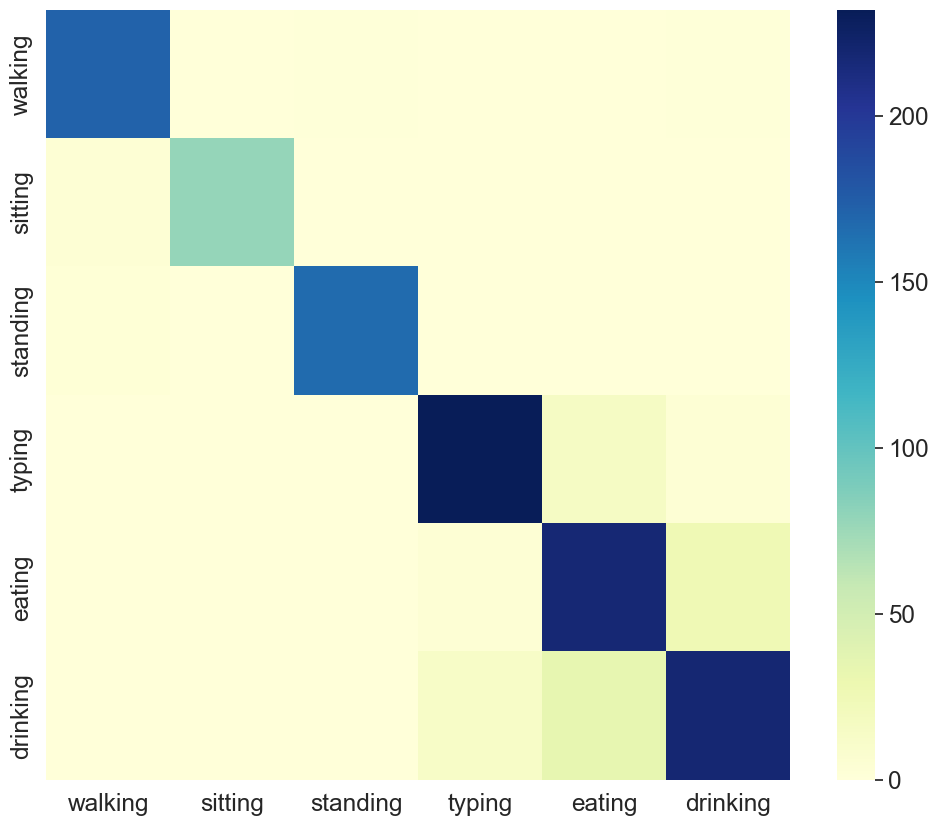

In [181]:
my_cv = StratifiedShuffleSplit(n_splits=5, train_size=0.7, test_size=0.3)

knn_classifier = KNeighborsClassifier()
my_param_grid = {'n_neighbors': [5, 10, 20], 'leaf_size': [20, 30, 40]}
knn_model_gs = GridSearchCV(estimator = knn_classifier, 
                            param_grid = my_param_grid,
                            cv = my_cv, 
                            scoring ='accuracy')

knn_model_gs.fit(X_train, y_train)

knn_best_classifier = knn_model_gs.best_estimator_

print(knn_model_gs.best_params_)

knn_model_gs.cv_results_

knn_best_classifier.get_params()

scores = cross_val_score(knn_best_classifier, X_train, y_train, cv=my_cv, scoring='accuracy')
list(scores)

# Applying model to train set first, just to verify that there is no substantial overfitting
y_train_pred=knn_best_classifier.predict(X_train)

accuracy_score(y_true=y_train, y_pred=y_train_pred)

y_test_pred = knn_best_classifier.predict(X_test)

cm = confusion_matrix(y_true=y_test,
                      y_pred=y_test_pred)
    
cm_act = pd.DataFrame(cm,
                      index = knn_best_classifier.classes_,
                      columns = knn_best_classifier.classes_)

cm_act.columns = activity_codes_mapping.values()
cm_act.index = activity_codes_mapping.values()
print(cm_act)

sns.set(font_scale=1.6)
fig, ax = plt.subplots(figsize=(12,10))
_ = sns.heatmap(cm_act, cmap="YlGnBu")
plt.savefig('knn_confusion_matrix.svg')

sns.set(font_scale=1.2)

accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(6)],index=activity_codes_mapping.values())
print(accuracy_per_activity)

print(classification_report(y_true=y_test,
                            y_pred=y_test_pred))

accuracy_score(y_true = y_test, y_pred = y_test_pred)

---
# local data processing

---

In [182]:
def apply_to_local(data, window_size=200):
    num_windows = len(data) // window_size  # Ensure full windows only
    all_features = []

    for i in range(num_windows):
        start = i * window_size
        end = start + window_size
        window = data.iloc[start:end]
        features = compute_features(window)
        all_features.append(features)

    return pd.DataFrame(all_features)

# walking test
df = pd.read_csv('local/sitting/test/1128_0718.csv', sep = ',', header=0, index_col=False ,names = ['time','sensor','accelx','accely','accelz','AVx','AVy','AVz','Ax','Ay','Az','temp'])
df.drop(['time','sensor','AVx','AVy','AVz','Ax','Ay','Az','temp'], axis = 1, inplace = True)
df.columns = ['x', 'y', 'z']
print(len(df))
df['x']=df['x'].astype('float')
df['y']=df['y'].astype('float')
df['z']=df['z'].astype('float')

local_features = apply_to_local(df)

scaling_transformer = MaxAbsScaler().fit(local_features[['xAVG', 'yAVG', 'zAVG', 'xPEAK', 'yPEAK', 'zPEAK', 'xABSOLDEV', 'yABSOLDEV', 'zABSOLDEV', 'RESULTANT']])
local_features[['xAVG', 'yAVG', 'zAVG', 'xPEAK', 'yPEAK', 'zPEAK', 'xABSOLDEV', 'yABSOLDEV', 'zABSOLDEV', 'RESULTANT']] = scaling_transformer.transform(local_features[['xAVG', 'yAVG', 'zAVG', 'xPEAK', 'yPEAK', 'zPEAK', 'xABSOLDEV', 'yABSOLDEV', 'zABSOLDEV', 'RESULTANT']])
print(len(local_features))
local_features

12356


/Users/zehaokou/miniconda3/envs/llama/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=200
  warnings.warn(


61


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,zMFCC10,zMFCC11,zMFCC12,xyCOS,xyCOR,xzCOS,xzCOR,yzCOS,yzCOR,RESULTANT
0,0.005,0.00,0.000,0.000,0.000,0.000,0.000,0.005,0.00,0.990,...,2.616766,3.118100,2.950492,0.260975,0.218091,1.721006,-0.207386,1.991685,-0.977626,1.000000
1,0.030,0.01,0.220,0.140,0.145,0.170,0.160,0.090,0.02,0.015,...,6.408941,1.871234,5.373219,0.021879,0.295407,1.958147,0.457400,1.991361,-0.134335,0.938728
2,0.280,0.38,0.185,0.045,0.080,0.020,0.000,0.000,0.00,0.010,...,6.718080,5.425056,3.646722,0.006420,-0.075791,1.995391,-0.294408,1.997804,-0.442254,0.936402
3,0.010,0.02,0.040,0.070,0.070,0.190,0.180,0.250,0.08,0.090,...,6.592919,5.874168,6.150224,0.007607,-0.394391,1.993095,0.250397,1.997283,0.098124,0.942298
4,0.030,0.01,0.030,0.110,0.425,0.210,0.110,0.020,0.01,0.045,...,7.663655,5.196396,8.019130,0.006084,0.373131,1.992113,-0.114918,1.996018,0.302488,0.944322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.015,0.09,0.180,0.165,0.110,0.080,0.040,0.160,0.10,0.060,...,7.151619,5.720378,5.799127,0.008852,-0.696487,1.993550,-0.105151,1.998403,0.686214,0.943661
57,0.010,0.01,0.020,0.195,0.530,0.205,0.000,0.010,0.01,0.010,...,4.070220,5.701985,7.978306,0.019623,0.322478,1.982212,-0.428184,1.997379,-0.630880,0.944555
58,0.030,0.01,0.120,0.245,0.280,0.165,0.070,0.030,0.02,0.030,...,5.965396,5.117846,4.658535,0.000621,-0.574255,1.999459,0.072507,1.999914,0.559115,0.944194
59,0.030,0.02,0.030,0.030,0.025,0.040,0.165,0.270,0.27,0.120,...,5.978493,5.426339,5.121846,0.001060,-0.413709,1.999198,-0.246512,1.999780,0.793881,0.943763


In [183]:
y_local_pred = knn_best_classifier.predict(local_features)

pd.DataFrame(y_local_pred)

,0
0,J
1,D
2,D
3,D
4,D
...,...
56,D
57,D
58,D
59,D
